# FootballAdChanger - Dataset Analysis

**Dataset Stats:**
- 45 immagini totali
- 121 banner pubblicitari annotati
- 20 immagini con annotazioni
- Media 6 banner per immagine
- Max 22 banner su singola immagine

In [1]:
# Setup
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

plt.rcParams['figure.figsize'] = (15, 10)
DATA_DIR = '../data'
IMAGES_DIR = '../data/raw/images'
ANNOTATIONS_FILE = '../data/annotations/instances.json'

print('✅ Setup completato!')

✅ Setup completato!


In [2]:
# Verifica accesso alle immagini
print(f"📂 Directory immagini: {IMAGES_DIR}")
if os.path.exists(IMAGES_DIR):
    image_files = os.listdir(IMAGES_DIR)
    print(f"✅ Trovate {len(image_files)} immagini")
    print(f"📝 Prime 5: {image_files[:5]}")
else:
    print("❌ Directory immagini non trovata!")

📂 Directory immagini: ../data/raw/images
✅ Trovate 45 immagini
📝 Prime 5: ['frame_00016.jpg', 'frame_00010.jpg', 'frame_00142.jpg', 'frame_00044.jpg', 'frame_00063.jpg']


In [4]:
# Carica dataset COCO
with open(ANNOTATIONS_FILE, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

print(f'📊 Dataset caricato:')
print(f'   Immagini: {len(images)}')
print(f'   Annotazioni: {len(annotations)}')
print(f'   Categorie: {len(categories)}')

# Crea mapping image_id -> annotazioni
img_annotations = {}
for ann in annotations:
    img_id = ann['image_id']
    if img_id not in img_annotations:
        img_annotations[img_id] = []
    img_annotations[img_id].append(ann)

print(f'🎯 Immagini con banner: {len(img_annotations)}/45')

📊 Dataset caricato:
   Immagini: 45
   Annotazioni: 121
   Categorie: 1
🎯 Immagini con banner: 20/45


In [8]:
# Verifica se abbiamo segmentazioni poligonali
print("🔍 Analisi formato annotazioni:")
print("=" * 40)

sample_annotation = annotations[0]
print("📝 Campi disponibili in ogni annotazione:")
for key, value in sample_annotation.items():
    print(f"   {key}: {type(value)} = {value}")

# Controlla se abbiamo segmentazioni
has_segmentation = any('segmentation' in ann for ann in annotations)
print(f"\n🎯 Segmentazioni disponibili: {'✅ SÌ' if has_segmentation else '❌ NO'}")

if has_segmentation:
    # Analizza i tipi di segmentazione
    seg_types = []
    for ann in annotations[:10]:  # Prime 10 per test
        if 'segmentation' in ann:
            seg = ann['segmentation']
            if isinstance(seg, list) and len(seg) > 0:
                if isinstance(seg[0], list):
                    seg_types.append("poligono")
                else:
                    seg_types.append("RLE")
            else:
                seg_types.append("vuota")
    
    print(f"📊 Tipi segmentazione trovati: {set(seg_types)}")
    
    # Mostra un esempio di segmentazione poligonale
    for ann in annotations[:5]:
        if 'segmentation' in ann and isinstance(ann['segmentation'], list) and len(ann['segmentation']) > 0:
            seg = ann['segmentation'][0]
            if isinstance(seg, list) and len(seg) > 4:  # Almeno 3 punti (6 coordinate)
                print(f"\n📐 Esempio poligono (annotation {ann['id']}):")
                print(f"   Punti: {len(seg)//2}")
                print(f"   Coordinate: {seg[:8]}... (prime 4 coordinate)")
                break

🔍 Analisi formato annotazioni:
📝 Campi disponibili in ogni annotazione:
   id: <class 'int'> = 1
   image_id: <class 'int'> = 1
   category_id: <class 'int'> = 1
   segmentation: <class 'list'> = [[254.2, 59.3, 261.7, 72.1, 640, 83.6, 640, 69.4, 550, 67, 535, 67, 473, 65, 452.5, 64.9, 431, 64, 424, 63, 248.4, 57.2, 120, 50.7, 32, 47.8, 0.1, 53.4, 0, 71.9, 37.9, 62.5, 39.7, 51.1, 41.9, 61.8, 249.5, 71.6]]
   area: <class 'int'> = 9046
   bbox: <class 'list'> = [0, 47.8, 640, 35.8]
   iscrowd: <class 'int'> = 0
   attributes: <class 'dict'> = {'occluded': False}

🎯 Segmentazioni disponibili: ✅ SÌ
📊 Tipi segmentazione trovati: {'poligono'}

📐 Esempio poligono (annotation 1):
   Punti: 19
   Coordinate: [254.2, 59.3, 261.7, 72.1, 640, 83.6, 640, 69.4]... (prime 4 coordinate)


In [5]:
# Visualizza immagini con più banner
# Trova le immagini con più banner
img_banner_count = [(img_id, len(anns)) for img_id, anns in img_annotations.items()]
img_banner_count.sort(key=lambda x: x[1], reverse=True)

print('🏆 TOP 10 - Immagini con più banner:')
for i, (img_id, count) in enumerate(img_banner_count[:10]):
    img_info = next(img for img in images if img['id'] == img_id)
    print(f'{i+1:2d}. {img_info["file_name"]} → {count} banner')

🏆 TOP 10 - Immagini con più banner:
 1. frame_00027.jpg → 22 banner
 2. frame_00025.jpg → 10 banner
 3. frame_00026.jpg → 10 banner
 4. frame_00016.jpg → 9 banner
 5. frame_00030.jpg → 8 banner
 6. frame_00003.jpg → 7 banner
 7. frame_00015.jpg → 7 banner
 8. frame_00008.jpg → 6 banner
 9. frame_00032.jpg → 6 banner
10. frame_00010.jpg → 5 banner


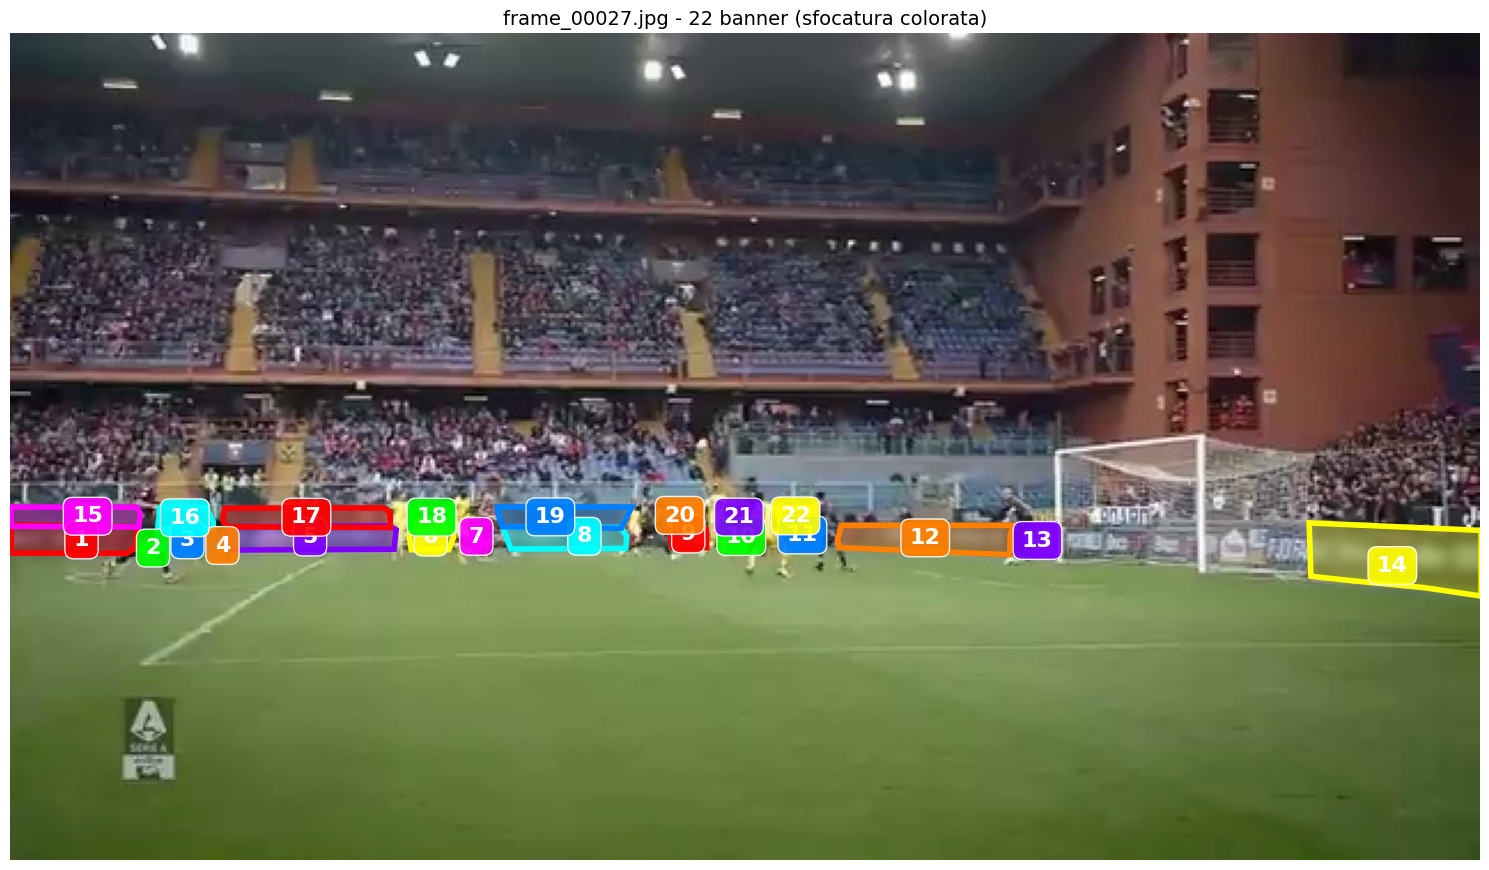

In [9]:
# Funzione per visualizzare immagini con banner poligonali + sfocatura colorata
def visualize_image_with_banners(img_id, ax=None):
    # Trova info immagine
    img_info = next(img for img in images if img['id'] == img_id)
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])
    
    if not os.path.exists(img_path):
        print(f'❌ Immagine non trovata: {img_path}')
        return
    
    # Carica immagine
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_effects = img_rgb.copy()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Disegna banner con poligoni e sfocatura
    if img_id in img_annotations:
        for i, ann in enumerate(img_annotations[img_id]):
            # Colori diversi per ogni banner
            colors_hex = ['#FF0000', '#00FF00', '#0080FF', '#FF8000', '#8000FF', '#FFFF00', '#FF00FF', '#00FFFF']
            colors_rgb = [
                [255, 0, 0], [0, 255, 0], [0, 128, 255], [255, 128, 0], 
                [128, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255]
            ]
            color_hex = colors_hex[i % len(colors_hex)]
            color_rgb = colors_rgb[i % len(colors_rgb)]
            
            # Ottieni segmentazione poligonale
            if 'segmentation' in ann and len(ann['segmentation']) > 0:
                segmentation = ann['segmentation'][0]  # Prendi il primo poligono
                
                # Converti in array numpy di punti (x,y)
                points = np.array(segmentation).reshape(-1, 2)
                
                # Crea maschera per il poligono
                mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
                cv2.fillPoly(mask, [points.astype(np.int32)], 255)
                
                # Applica sfocatura colorata all'area del poligono
                # Crea versione sfocata dell'immagine
                blurred = cv2.GaussianBlur(img_rgb, (15, 15), 0)
                
                # Crea overlay colorato
                color_overlay = np.full_like(img_rgb, color_rgb, dtype=np.uint8)
                
                # Mescola immagine sfocata con overlay colorato
                blurred_colored = cv2.addWeighted(blurred, 0.7, color_overlay, 0.3, 0)
                
                # Applica l'effetto solo nell'area della maschera
                mask_3d = np.dstack([mask, mask, mask]) / 255.0
                img_with_effects = img_with_effects * (1 - mask_3d) + blurred_colored * mask_3d
                
    # Converti a uint8
    img_with_effects = img_with_effects.astype(np.uint8)
    
    # Mostra l'immagine con effetti
    ax.imshow(img_with_effects)
    
    # Disegna i bordi dei poligoni sopra
    if img_id in img_annotations:
        for i, ann in enumerate(img_annotations[img_id]):
            colors_hex = ['#FF0000', '#00FF00', '#0080FF', '#FF8000', '#8000FF', '#FFFF00', '#FF00FF', '#00FFFF']
            color_hex = colors_hex[i % len(colors_hex)]
            
            if 'segmentation' in ann and len(ann['segmentation']) > 0:
                segmentation = ann['segmentation'][0]
                points = np.array(segmentation).reshape(-1, 2)
                
                # Disegna solo il bordo del poligono
                polygon_border = plt.Polygon(
                    points, 
                    linewidth=4, 
                    edgecolor=color_hex, 
                    facecolor='none',
                    linestyle='-'
                )
                ax.add_patch(polygon_border)
                
                # Numero del banner al centro del poligono
                center_x = np.mean(points[:, 0])
                center_y = np.mean(points[:, 1])
                
                ax.text(
                    center_x, center_y, f'{i+1}',
                    color='white', fontsize=16, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(facecolor=color_hex, alpha=0.9, edgecolor='white', boxstyle='round,pad=0.4')
                )
    
    banner_count = len(img_annotations.get(img_id, []))
    ax.set_title(f'{img_info["file_name"]} - {banner_count} banner (sfocatura colorata)', fontsize=14)
    ax.axis('off')
    
    return ax

# Test con l'immagine con più banner
top_img_id = img_banner_count[0][0]
visualize_image_with_banners(top_img_id)
plt.tight_layout()
plt.show()

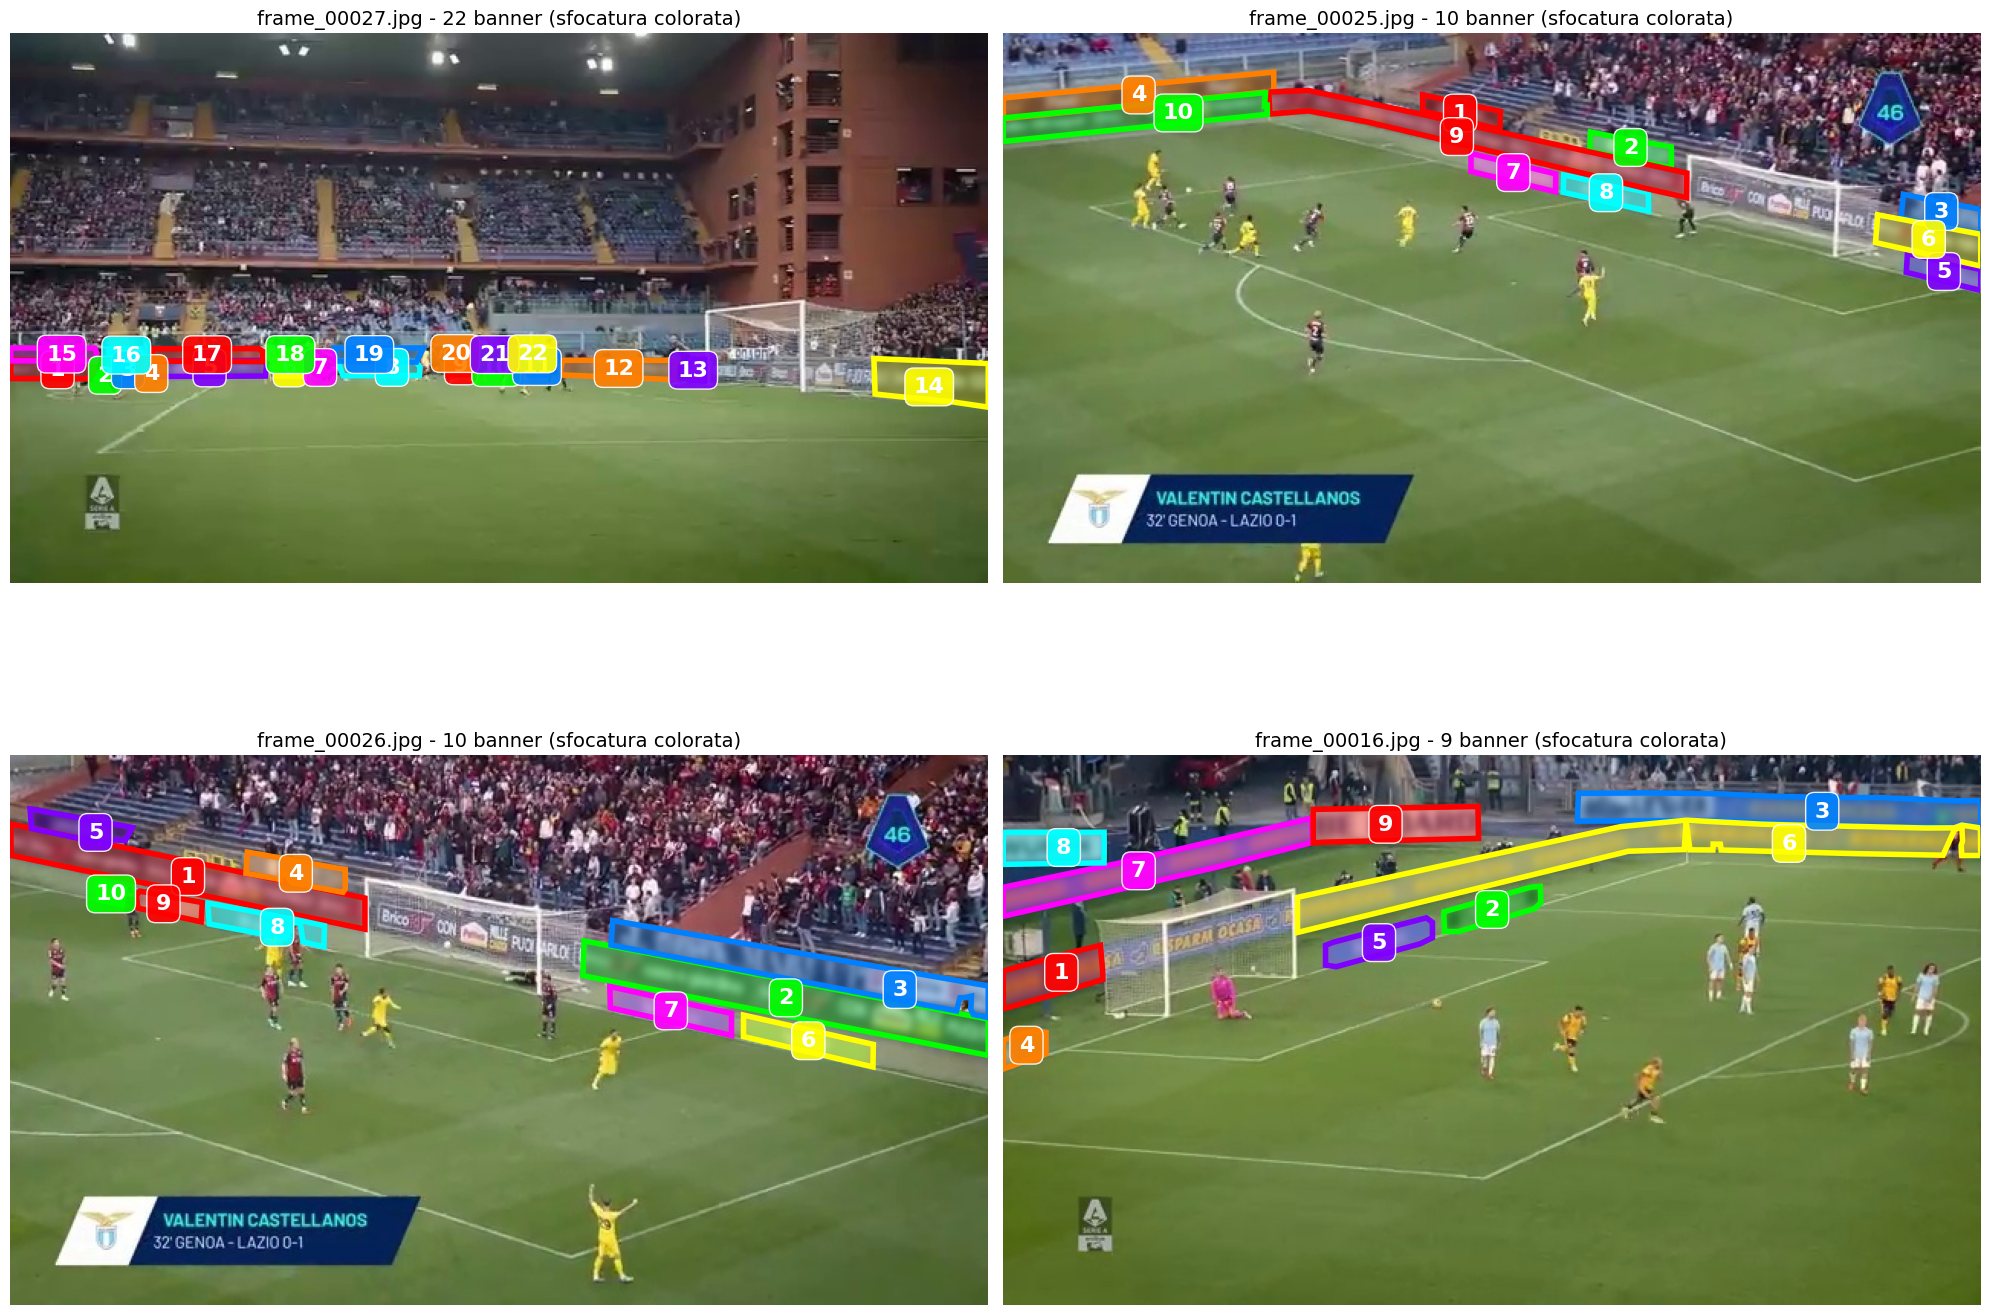

In [10]:
# Visualizza le TOP 4 immagini con sfocatura colorata
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i in range(4):
    img_id = img_banner_count[i][0]
    visualize_image_with_banners(img_id, axes[i])

plt.tight_layout()
plt.show()